In [1]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

from skimage import data, util
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split

from gmm_seg_classifier import GaussianModel, GaussianMixtureModel
from roipoly import RoiPoly

# suppress depreciation warning from numpy 1.25.0
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def segment_and_write_masks(train_path, mask_path):
    for filename in os.listdir(train_path):
        if filename.endswith(('.png', '.jpg')):
            img = cv2.imread(os.path.join(train_path,filename))
            img = util.img_as_ubyte(img)

            fig = plt.figure()
            plt.imshow(img, interpolation='nearest', cmap="Greys")
            plt.colorbar()
            plt.title("left click: line segment         right click or double click: close region")
            plt.show(block=False)

            # Let user draw first ROI
            roi = RoiPoly(color='r', fig=fig)
            mask = roi.get_mask(img[:,:,0])
            mask = mask.astype(np.uint8) * 255
            # save binary mask to file
            cv2.imwrite(os.path.join(mask_path, filename), mask)

In [3]:
# make some utils
def read_img_to_array(fp):
    # read image file into 8-bit encoded image
    img = cv2.imread(fp)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = util.img_as_ubyte(img)
    return img

def read_mask_to_array(fp):
    # read image file into binary mask
    img = cv2.imread(fp)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = util.img_as_ubyte(img)
    _, binary_mask = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    return binary_mask > 0

In [4]:
train_path = 'data/img/train'
mask_path = 'data/mask/train'

# import image
filenames = os.listdir(train_path)

for f in filenames:
    assert f.endswith(('.png', '.jpg'))

train_files, test_files = train_test_split(filenames, test_size=0.2)
print(len(train_files), len(test_files))

20 5


In [66]:
# train
X_cone = []
X_bg = []
for filename in train_files:
    # assemble into set of pixels X
    img = read_img_to_array(os.path.join(train_path,filename))
    mask = read_mask_to_array(os.path.join(mask_path, filename))
    cone = img[mask]
    background = img[np.invert(mask)]

    X_cone.append(cone)
    X_bg.append(background)
    
X_cone = np.concatenate(X_cone)
X_bg = np.concatenate(X_bg)

n_cone_pixel = X_cone.shape[0]
n_bg_pixel = X_bg.shape[0]
p_cone = n_cone_pixel / (n_cone_pixel + n_bg_pixel)

cone_gaussian_model_train = GaussianModel()
bg_gaussian_model_train = GaussianModel()

cone_gaussian_model_train.fit(X_cone)
bg_gaussian_model_train.fit(X_bg)

cone_gaussian_model_train.save_to_json('pretrained_model/cone_gaussian_model.json')
bg_gaussian_model_train.save_to_json('pretrained_model/bg_gaussian_model.json')


In [10]:
cone_gaussian_model = GaussianModel()
bg_gaussian_model = GaussianModel()

cone_gaussian_model.load('pretrained_model/cone_gaussian_model.json')
bg_gaussian_model.load('pretrained_model/bg_gaussian_model.json')

n_cone_pixel = 63866
n_bg_pixel = 9536134
p_cone = n_cone_pixel / (n_cone_pixel + n_bg_pixel)

In [67]:
cone_gmm_train = GaussianMixtureModel(n_components=2)
bg_gmm_train = GaussianMixtureModel(n_components=2)

cone_gmm_train.fit(X_cone)
bg_gmm_train.fit(X_bg)

cone_gmm_train.save_to_json('pretrained_model/cone_gaussian_model.json')
bg_gmm_train.save_to_json('pretrained_model/bg_gaussian_model.json')


Iteration 0: log-likelihood = -522620.45025622897
Iteration 1: log-likelihood = -522611.0604182425
Iteration 2: log-likelihood = -522547.17060165084
Iteration 3: log-likelihood = -522036.11557400157
Iteration 4: log-likelihood = -518501.35060963524
Iteration 5: log-likelihood = -502480.6891033522
Iteration 6: log-likelihood = -500113.99821825547
Iteration 7: log-likelihood = -507074.3235644409
Iteration 8: log-likelihood = -488452.80053418654
Iteration 9: log-likelihood = -502944.7312400011
Iteration 10: log-likelihood = -505405.97605166445
Iteration 11: log-likelihood = -485020.484123263
Iteration 12: log-likelihood = -501174.5821310852
Iteration 13: log-likelihood = -504863.53214096295
Iteration 14: log-likelihood = -484992.45663122565
Iteration 15: log-likelihood = -501175.9254629288
Iteration 16: log-likelihood = -504863.13192421885


In [ ]:
cone_gmm = GaussianMixtureModel(n_components=2) 
bg_gmm = GaussianMixtureModel(n_components=2)
cone_gmm.load('pretrained_model/cone_gaussian_model.json')
bg_gmm.load('pretrained_model/bg_gaussian_model.json')

In [12]:
# image processing
def classify_image_pixels(image):
    W, H, _ = image.shape
    mask = np.zeros((W,H))
    for x in range(W):
        for y in range(H):
            pixel = image[x,y,:]
            p_x_cone = cone_gaussian_model.predict(pixel)
            p_x_bg = bg_gaussian_model.predict(pixel)
            p_x = ((p_x_cone * p_cone) + p_x_bg * (1 - p_cone))
            p_cone_x = (p_x_cone * p_cone) / p_x
            mask[x,y] = p_cone_x[0]

    return mask 


def draw_triangle_around_positive_pixels(image, thresh):
    mask = classify_image_pixels(image)

    #dilation and erosion to clean up
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = mask
    mask_cleaned = cv2.erode(mask_cleaned, kernel,iterations = 1)
    mask_cleaned = cv2.dilate(mask_cleaned, kernel,iterations = 3)
    mask_cleaned = cv2.erode(mask_cleaned, kernel,iterations = 2)

    mask_cleaned = cv2.erode(mask_cleaned, kernel,iterations = 1)
    mask_cleaned = cv2.dilate(mask_cleaned, kernel,iterations = 1)
    # mask_cleaned = cv2.dilate(mask_cleaned, kernel,iterations = 2)
    # mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = mask_cleaned > thresh

    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for cnt in contours:
         # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        cv2.drawContours(image, approx, -1, (0, 0, 255), 4)
        x, y, w, h = cv2.boundingRect(approx)
        t = np.array([
            [x + w // 2, y], # top
            [x, y + h], # right
            [x + w, y + h] # left
        ])

        # geometry constraint
        w_h_ratio = 17 / 7.5 
        if h / w > (w_h_ratio - 0.5):
            triangles.append(t)
            cv2.drawContours(image, [t], 0, (0, 255, 0), 2)  # Green, tickness 2

    return image, triangles

# geometry processing
def triangle_geometry(triangle):
    base = triangle[1:] # drop the top point
    centroid = np.mean(base, axis=0).squeeze().astype(int)
    x = centroid[0]
    y = centroid[1]

    f = 50 # hand-calculated focal length
    h = np.abs(triangle[0][1] - triangle[1][1])
    w = np.abs(triangle[1][0] - triangle[2][0])
    # average of distance estimates from height and width
    d_1 = f * 17 / h
    d_2 = f * 7.5 / w
    d = (d_1 + d_2) / 2

    return x, y, d


# Visualization

## Train set

ImageNo = [16], CentroidX = 439.000, CentroidY = 470.000, Distance = 23.986
ImageNo = [20], CentroidX = 181.000, CentroidY = 493.000, Distance = 7.270
ImageNo = [1], CentroidX = 313.000, CentroidY = 431.000, Distance = 30.804
ImageNo = [1], CentroidX = 345.000, CentroidY = 253.000, Distance = 59.478
ImageNo = [29], CentroidX = 310.000, CentroidY = 566.000, Distance = 6.831
ImageNo = [7], CentroidX = 454.000, CentroidY = 585.000, Distance = 9.257
ImageNo = [2], CentroidX = 58.000, CentroidY = 521.000, Distance = 22.435
ImageNo = [2], CentroidX = 362.000, CentroidY = 446.000, Distance = 32.460
ImageNo = [2], CentroidX = 161.000, CentroidY = 471.000, Distance = 8.609
ImageNo = [26], CentroidX = 482.000, CentroidY = 424.000, Distance = 30.280
ImageNo = [31], CentroidX = 298.000, CentroidY = 613.000, Distance = 9.234
ImageNo = [22], CentroidX = 482.000, CentroidY = 348.000, Distance = 6.312
ImageNo = [12], CentroidX = 429.000, CentroidY = 498.000, Distance = 7.109
ImageNo = [17], CentroidX 

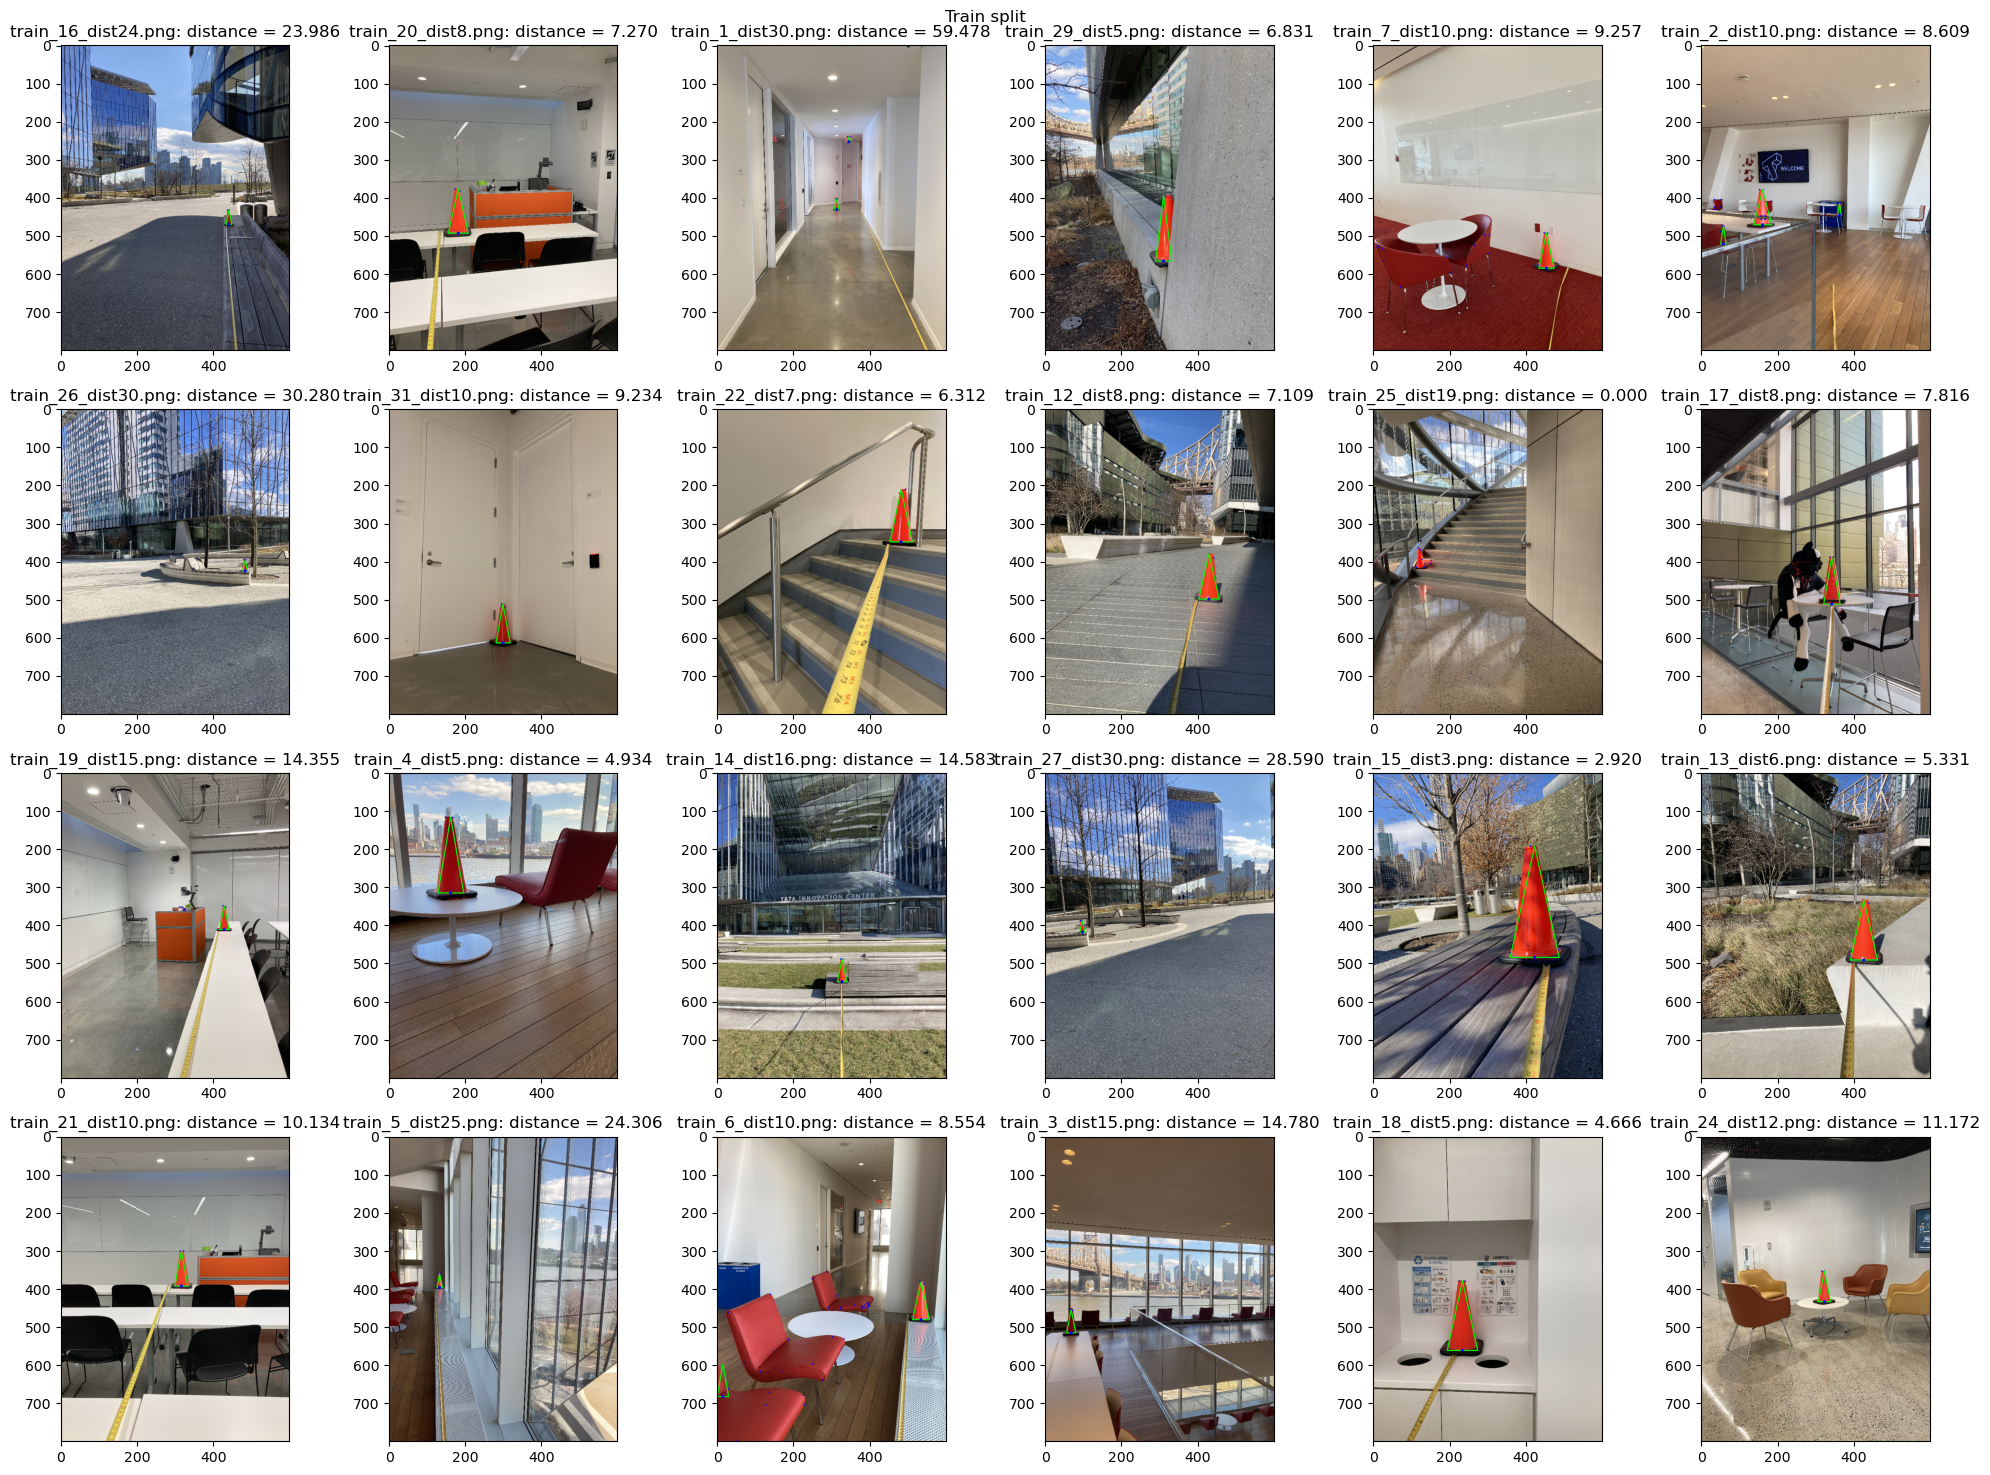

In [16]:
# Train split
######################################
# params
target_files = filenames
thresh = 0.99
######################################

shapes = []
# set up nice plots
n_subplots = len(target_files)
rows = math.ceil(len(filenames) / 8)
fig, axs = plt.subplots(rows, 6, figsize=(20, 15))

for ax, filename in zip(axs.flat, target_files):
    # reset 
    x = None
    y = None
    d = 0

    pattern = r"train_(\d+)_dist"
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    # Extract the imgNumber if a match is found
    imgNumber = match.group(1) if match else None

    # assemble into set of pixels X
    img = read_img_to_array(os.path.join(train_path,filename))
    img_overlay, triangles = draw_triangle_around_positive_pixels(img, thresh)
    
    for t in triangles:
        shapes.append(t)
        x, y, d = triangle_geometry(t)
        # draw blue dot at centroid
        cv2.circle(img_overlay, (x,y), radius=4, color=(0, 0, 255), thickness=-1)

        print(f'ImageNo = [{imgNumber}], CentroidX = {x:.3f}, CentroidY = {y:.3f}, Distance = {d:.3f}')

    ax.imshow(img_overlay)
    ax.set_title(f'{filename}: distance = {d:.3f}')

fig.suptitle('Train split')
plt.tight_layout()
plt.show()

## Validation Set

ImageNo = [18], CentroidX = 234.000, CentroidY = 562.000, Distance = 4.666
ImageNo = [7], CentroidX = 454.000, CentroidY = 585.000, Distance = 9.257
ImageNo = [15], CentroidX = 423.000, CentroidY = 483.000, Distance = 2.920
ImageNo = [26], CentroidX = 482.000, CentroidY = 424.000, Distance = 30.280


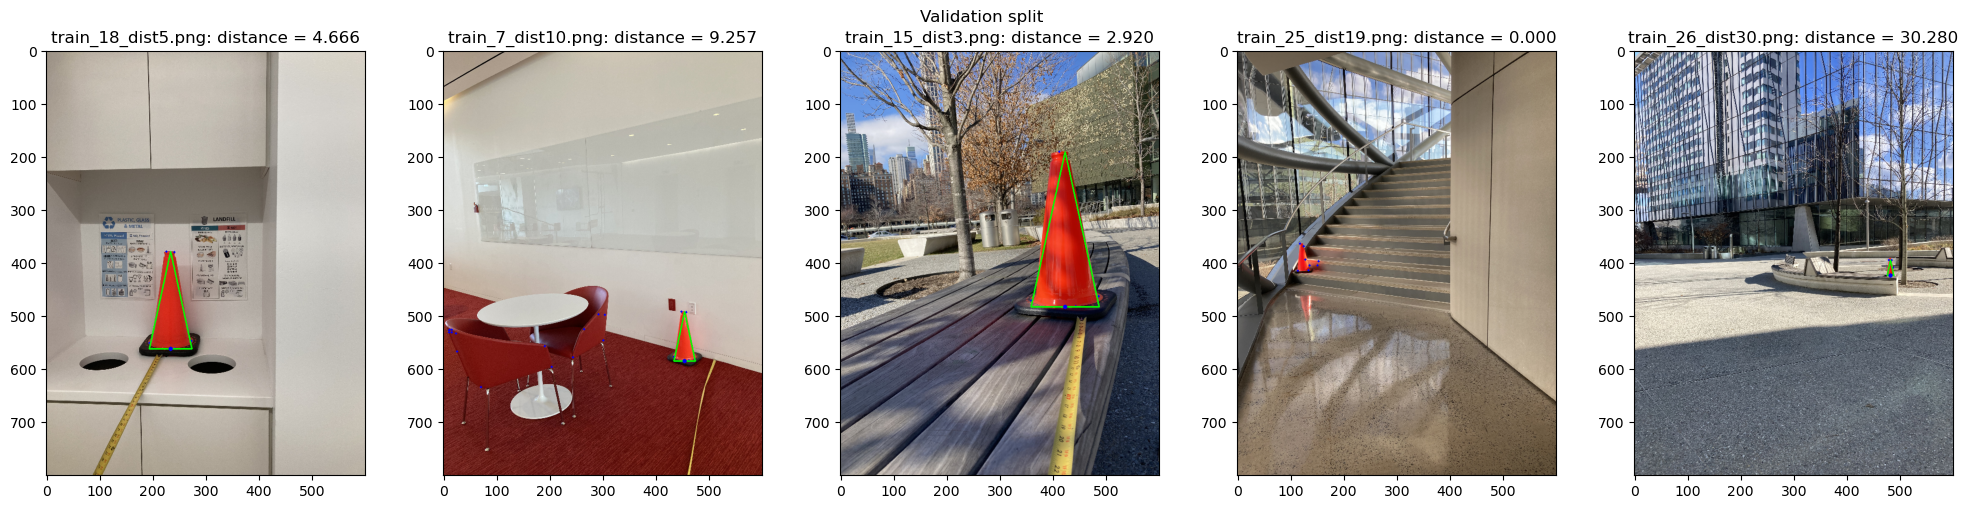

In [17]:
# Validation split
######################################
# params
target_files = test_files
thresh = 0.99
######################################

shapes = []
# set up nice plots
n_subplots = len(target_files)
rows = math.ceil(len(target_files) / 5)
fig, axs = plt.subplots(rows, 5, figsize=(20, 5))

for ax, filename in zip(axs.flat, target_files):
    # reset 
    x = None
    y = None
    d = 0

    pattern = r"train_(\d+)_dist"
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    # Extract the imgNumber if a match is found
    imgNumber = match.group(1) if match else None

    # assemble into set of pixels X
    img = read_img_to_array(os.path.join(train_path,filename))
    img_overlay, triangles = draw_triangle_around_positive_pixels(img, thresh)
    
    for t in triangles:
        shapes.append(t)
        x, y, d = triangle_geometry(t)
        # draw blue dot at centroid
        cv2.circle(img_overlay, (x,y), radius=4, color=(0, 0, 255), thickness=-1)

        print(f'ImageNo = [{imgNumber}], CentroidX = {x:.3f}, CentroidY = {y:.3f}, Distance = {d:.3f}')

    ax.imshow(img_overlay)
    ax.set_title(f'{filename}: distance = {d:.3f}')

fig.suptitle('Validation split')
plt.tight_layout()
plt.show()

## Test Set

In [18]:
test_path = 'data/img/test'
test_files = os.listdir(test_path)
test_files = [file for file in test_files if file != ".DS_Store"]

ImageNo = [3], CentroidX = 319.000, CentroidY = 453.000, Distance = 7.622
ImageNo = [2], CentroidX = 470.000, CentroidY = 531.000, Distance = 3.737
ImageNo = [1], CentroidX = 228.000, CentroidY = 522.000, Distance = 7.583
ImageNo = [5], CentroidX = 261.000, CentroidY = 451.000, Distance = 7.336
ImageNo = [5], CentroidX = 346.000, CentroidY = 600.000, Distance = 2.825
ImageNo = [4], CentroidX = 301.000, CentroidY = 419.000, Distance = 21.378


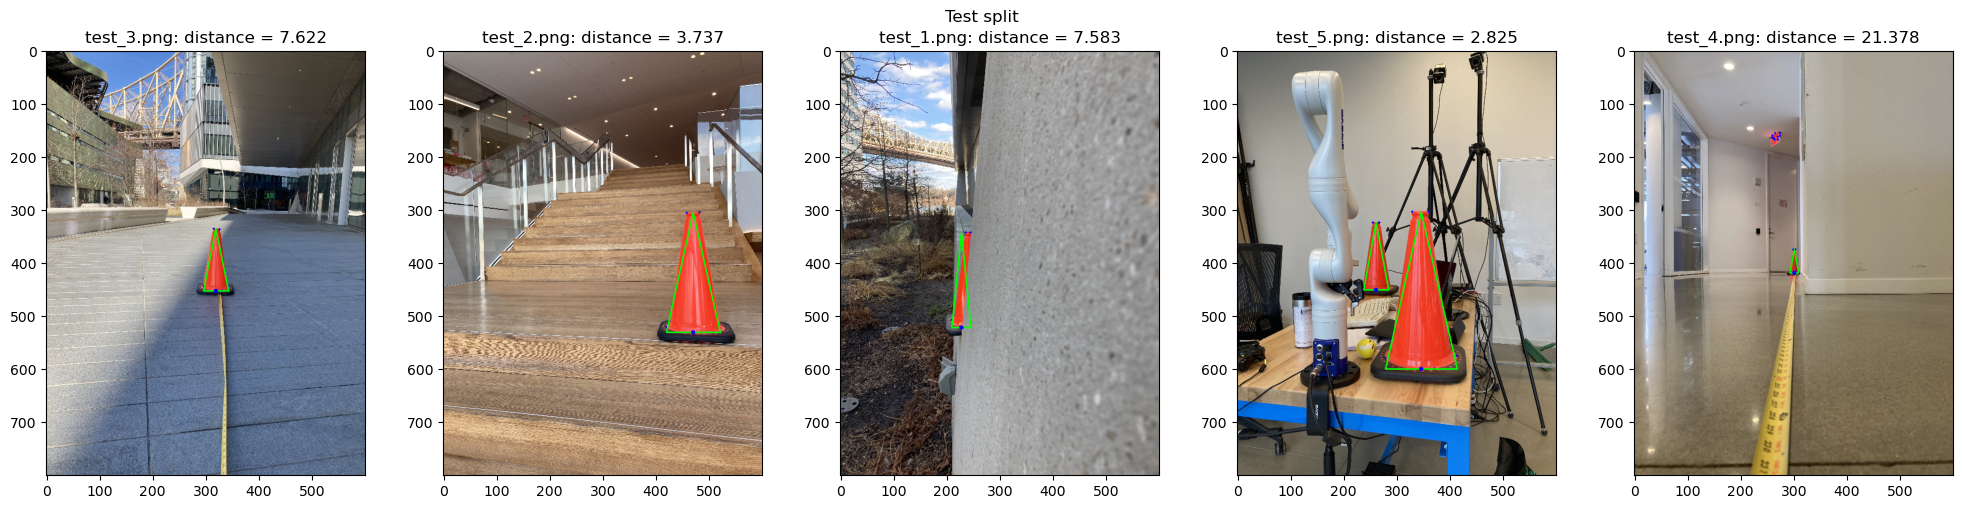

In [19]:
# Test Split
######################################
# params
target_files = test_files
thresh = 0.99
######################################

n_subplots = len(target_files)
rows = math.ceil(len(target_files) / 5)
fig, axs = plt.subplots(rows, 5, figsize=(20, 5))

for ax, filename  in zip(axs.flat, target_files):
    # reset 
    x = None
    y = None
    d = 0

    pattern = r"test_(\d+)"
    # Search for the pattern in the filename
    match = re.search(pattern, filename)
    # Extract the imgNumber if a match is found
    imgNumber = match.group(1) if match else None

    img = read_img_to_array(os.path.join(test_path,filename))
    img_overlay, triangles = draw_triangle_around_positive_pixels(img, thresh)

    for t in triangles:
        shapes.append(t)
        x, y, d = triangle_geometry(t)
        # draw blue dot at centroid
        cv2.circle(img_overlay, (x,y), radius=4, color=(0, 0, 255), thickness=-1)

        print(f'ImageNo = [{imgNumber}], CentroidX = {x:.3f}, CentroidY = {y:.3f}, Distance = {d:.3f}')

    ax.imshow(img_overlay)
    ax.set_title(f'{filename}: distance = {d:.3f}')

fig.suptitle('Test split')
plt.tight_layout()
plt.show()
